#  Geospatial Analysis of Remote Work and Employee Mental Health


## 1. Introduction

In this project, we use advanced AI tools—Large Language Models (LLMs), computer vision, and geospatial libraries—to analyze how remote work setups impact employee well-being across regions.

**Objectives:**

- Visualize employee locations on interactive maps.
- Use LLMs to extract mental health sentiment from open-text responses.
- Map average stress levels and work modalities by region.
- Map employees distribution geographically using data given in our dataset.
- Explore how remote work correlates with mental health conditions.
- Identify patterns in stress, productivity, and work-life balance.
- Discover which factors contribute to better mental health in remote environments.
- Propose data-driven recommendations to employers and policymakers.

**Main Goal:**
- Make a Web dashboard which will help employers assess mental health conditions of their employees.Employers will be recommended on a steps to take according to the employee's stress level

**Tools & Libraries:**
- `pandas`, `geopandas`, `folium`, `matplotlib`, `transformers`, `scikit-learn`, `mapclassify`


# Install Required Libraries

In [1]:
 !pip install openai pandas scikit-learn seaborn matplotlib tiktoken sentence-transformers 
 !pip install folium matplotlib mapclassify 

Defaulting to user installation because normal site-packages is not writeable


Defaulting to user installation because normal site-packages is not writeable


# 2.  Load and Preview Dataset

In [2]:
import pandas as pd

# Load the dataset
df = pd.read_csv("Impact_of_Remote_Work_on_Mental_Health.csv")
df.head()


Employee_ID  Age      Gender           Job_Role    Industry  \
0     EMP0001   32  Non-binary                 HR  Healthcare   
1     EMP0002   40      Female     Data Scientist          IT   
2     EMP0003   59  Non-binary  Software Engineer   Education   
3     EMP0004   27        Male  Software Engineer     Finance   
4     EMP0005   49        Male              Sales  Consulting   

   Years_of_Experience Work_Location  Hours_Worked_Per_Week  \
0                   13        Hybrid                     47   
1                    3        Remote                     52   
2                   22        Hybrid                     46   
3                   20        Onsite                     32   
4                   32        Onsite                     35   

   Number_of_Virtual_Meetings  Work_Life_Balance_Rating Stress_Level  \
0                           7                         2       Medium   
1                           4                         1       Medium   
2                          11                         5       Medium   
3                           8                         4         High   
4                          12                         2         High   

  Mental_Health_Condition Access_to_Mental_Health_Resources  \
0              Depression                                No   
1                 Anxiety                                No   
2                 Anxiety                                No   
3              Depression                               Yes   
4                     NaN                               Yes   

  Productivity_Change  Social_Isolation_Rating Satisfaction_with_Remote_Work  \
0            Decrease                        1                   Unsatisfied   
1            Increase                        3                     Satisfied   
2           No Change                        4                   Unsatisfied   
3            Increase                        3                   Unsatisfied   
4            Decrease                        3                   Unsatisfied   

   Company_Support_for_Remote_Work Physical_Activity Sleep_Quality  \
0                                1            Weekly          Good   
1                                2            Weekly          Good   
2                                5               NaN          Poor   
3                                3               NaN          Poor   
4                                3            Weekly       Average   

          Region  
0         Europe  
1           Asia  
2  North America  
3         Europe  
4  North America

#  3.  Data Profiling

In [3]:
# Quick inspection
df.info()

# Check for nulls
df.isnull().sum()

# Summary stats
df.describe()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 20 columns):
 #   Column                             Non-Null Count  Dtype 
---  ------                             --------------  ----- 
 0   Employee_ID                        5000 non-null   object
 1   Age                                5000 non-null   int64 
 2   Gender                             5000 non-null   object
 3   Job_Role                           5000 non-null   object
 4   Industry                           5000 non-null   object
 5   Years_of_Experience                5000 non-null   int64 
 6   Work_Location                      5000 non-null   object
 7   Hours_Worked_Per_Week              5000 non-null   int64 
 8   Number_of_Virtual_Meetings         5000 non-null   int64 
 9   Work_Life_Balance_Rating           5000 non-null   int64 
 10  Stress_Level                       5000 non-null   object
 11  Mental_Health_Condition            3804 non-null   object
 12  Access

Age  Years_of_Experience  Hours_Worked_Per_Week  \
count  5000.000000          5000.000000            5000.000000   
mean     40.995000            17.810200              39.614600   
std      11.296021            10.020412              11.860194   
min      22.000000             1.000000              20.000000   
25%      31.000000             9.000000              29.000000   
50%      41.000000            18.000000              40.000000   
75%      51.000000            26.000000              50.000000   
max      60.000000            35.000000              60.000000   

       Number_of_Virtual_Meetings  Work_Life_Balance_Rating  \
count                 5000.000000               5000.000000   
mean                     7.559000                  2.984200   
std                      4.636121                  1.410513   
min                      0.000000                  1.000000   
25%                      4.000000                  2.000000   
50%                      8.000000                  3.000000   
75%                     12.000000                  4.000000   
max                     15.000000                  5.000000   

       Social_Isolation_Rating  Company_Support_for_Remote_Work  
count              5000.000000                      5000.000000  
mean                  2.993800                         3.007800  
std                   1.394615                         1.399046  
min                   1.000000                         1.000000  
25%                   2.000000                         2.000000  
50%                   3.000000                         3.000000  
75%                   4.000000                         4.000000  
max                   5.000000                         5.000000

# 4. Geospatial Employee Mapping

In [4]:
import folium
from folium.plugins import MarkerCluster

# Add mock lat/lon values per region for demo (in real project: merge real lat/lon per Region)
region_coords = {
    "North America": [37.0902, -95.7129],
    "Europe": [54.5260, 15.2551],
    "Asia": [34.0479, 100.6197],
    "Africa": [-8.7832, 34.5085],
    "South America": [-14.2350, -51.9253],
    "Australia": [-25.2744, 133.7751]
}

df['Latitude'] = df['Region'].map(lambda x: region_coords.get(x, [0, 0])[0])
df['Longitude'] = df['Region'].map(lambda x: region_coords.get(x, [0, 0])[1])

map_center = [df['Latitude'].mean(), df['Longitude'].mean()]
employee_map = folium.Map(location=map_center, zoom_start=2)
cluster = MarkerCluster().add_to(employee_map)

for _, row in df.iterrows():
    folium.Marker(
        location=[row['Latitude'], row['Longitude']],
        popup=f"ID: {row['Employee_ID']} | Location: {row['Work_Location']}"
    ).add_to(cluster)

employee_map


#  5. Average Stress Levels by Region

In [5]:
import pandas as pd
import geopandas as gpd
import folium
from folium.plugins import MarkerCluster
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.pipeline import Pipeline
import shap
import joblib
import os

# Load the dataset
df = pd.read_csv("Impact_of_Remote_Work_on_Mental_Health.csv")

# Convert 'Stress_Level' from categorical strings to numerical values
stress_level_mapping = {
    'Low': 1,
    'Medium': 2,
    'High': 3,
}
df['Stress_Level'] = df['Stress_Level'].map(stress_level_mapping)

# Drop rows where Stress_Level couldn't be mapped
df.dropna(subset=['Stress_Level'], inplace=True)

# Geospatial coordinates for regions (manual mapping)
region_coords = {
    "North America": [37.0902, -95.7129],
    "Europe": [54.5260, 15.2551],
    "Asia": [34.0479, 100.6197],
    "Africa": [-8.7832, 34.5085],
    "South America": [-14.2350, -51.9253],
    "Australia": [-25.2744, 133.7751]
}

df['Latitude'] = df['Region'].map(lambda x: region_coords.get(x, [0, 0])[0])
df['Longitude'] = df['Region'].map(lambda x: region_coords.get(x, [0, 0])[1])

# Create interactive map of employee distribution
map_center = [df['Latitude'].mean(), df['Longitude'].mean()]
employee_map = folium.Map(location=map_center, zoom_start=2)
cluster = MarkerCluster().add_to(employee_map)

for _, row in df.iterrows():
    folium.Marker(
        location=[row['Latitude'], row['Longitude']],
        popup=f"ID: {row['Employee_ID']} | Location: {row['Work_Location']}"
    ).add_to(cluster)

# Display employee map (in Jupyter)
employee_map  # Note: Only displays in a Jupyter environment

# ---- Average Stress Level by Region ----
stress_by_region = df.groupby("Region")["Stress_Level"].mean().reset_index()

# Load country shapefile (make sure all .shp/.shx/.dbf/.prj files are in 'data/' folder)
world = gpd.read_file("110m_cultural/ne_110m_admin_0_countries.shp")

# Optional: Map high-level region labels to countries if needed
region_country_map = {
    "North America": ["United States of America", "Canada", "Mexico"],
    "Europe": ["France", "Germany", "United Kingdom", "Italy", "Spain", "Netherlands", "Belgium"],
    "Asia": ["China", "India", "Japan", "South Korea", "Indonesia", "Pakistan"],
    "Africa": ["Nigeria", "South Africa", "Egypt", "Kenya", "Ghana"],
    "South America": ["Brazil", "Argentina", "Colombia", "Chile", "Peru"],
    "Australia": ["Australia"]
}

# Create a new DataFrame to match stress level to individual countries
country_stress = []
for region, countries in region_country_map.items():
    avg_stress = stress_by_region.loc[stress_by_region['Region'] == region, 'Stress_Level'].values
    if len(avg_stress) > 0:
        for country in countries:
            country_stress.append({'ADMIN': country, 'Stress_Level': avg_stress[0]})

country_stress_df = pd.DataFrame(country_stress)

# Merge shapefile with stress data by country
geo_stress = world.merge(country_stress_df, on='ADMIN', how='left')

# Plot interactive choropleth map
geo_stress.explore(column="Stress_Level", cmap="YlOrRd", legend=True)


#  6. Work Location Modality by Region

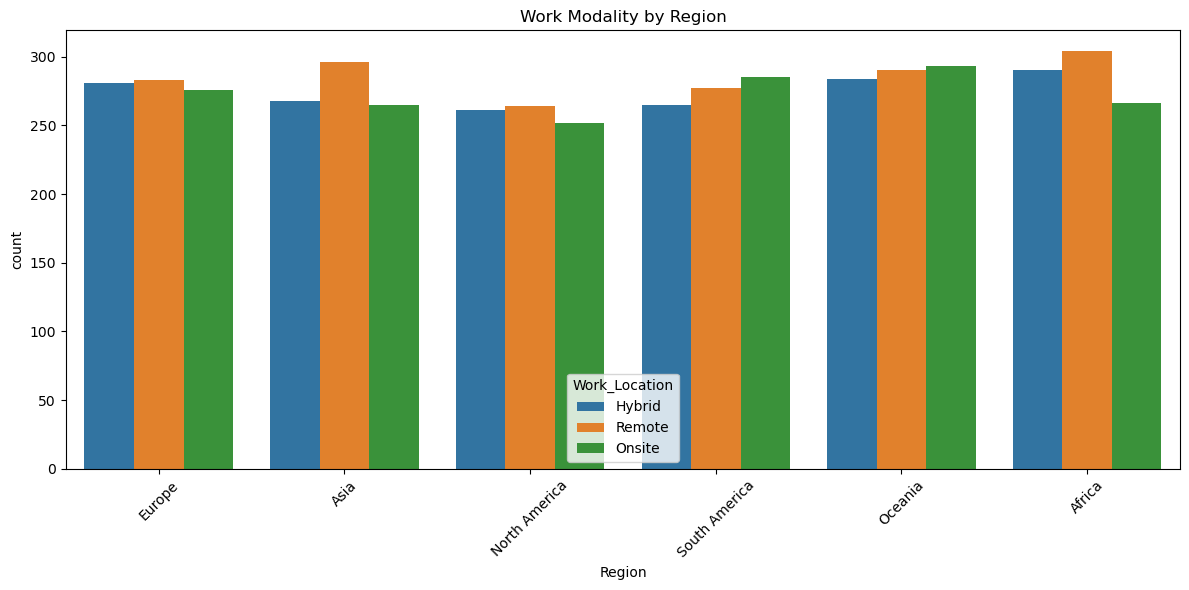

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
sns.countplot(data=df, x="Region", hue="Work_Location")
plt.title("Work Modality by Region")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# 7. Visualizing Average Sleep Quality by Region

/tmp/ipykernel_1378362/3580126768.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=sleep_avg, x="Region", y="Sleep_Quality", palette="coolwarm")


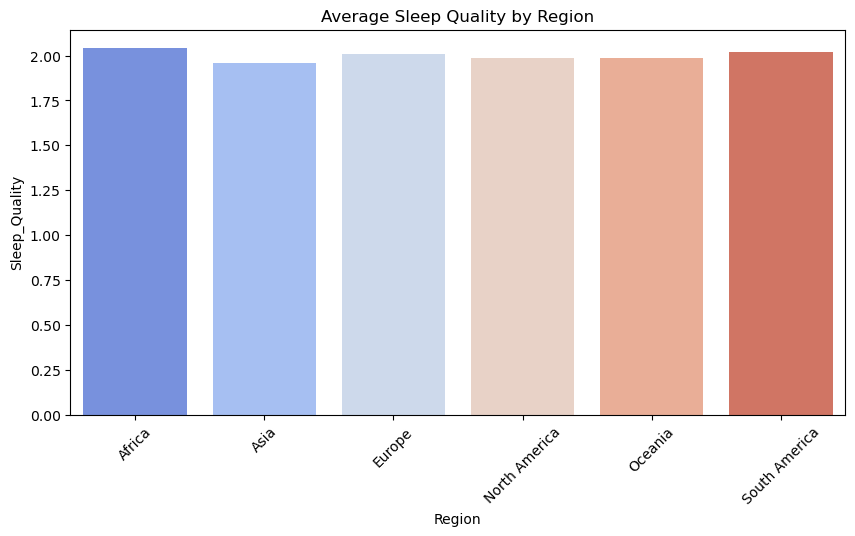

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Add this section to map 'Sleep_Quality' to numerical values
sleep_quality_mapping = {
    'Poor': 1,
    'Average': 2,
    'Good': 3
}
df['Sleep_Quality'] = df['Sleep_Quality'].map(sleep_quality_mapping)

# Drop rows where Sleep_Quality couldn't be mapped (optional, depending on how you want to handle missing values)
df.dropna(subset=['Sleep_Quality'], inplace=True)


sleep_avg = df.groupby("Region")["Sleep_Quality"].mean().reset_index()

plt.figure(figsize=(10, 5))
sns.barplot(data=sleep_avg, x="Region", y="Sleep_Quality", palette="coolwarm")
plt.title("Average Sleep Quality by Region")
plt.xticks(rotation=45)
plt.show()

# 8. Summary Statistics & Data Types

In [8]:
# Summary of numerical and categorical features
df.describe(include='all').T

# Count of each datatype
df.dtypes.value_counts()


object     11
int64       9
float64     2
Name: count, dtype: int64

# 9. Distribution of Target and Key Variables
Distribution of Mental Health Condition(Depression, Anxiety and Burnout)

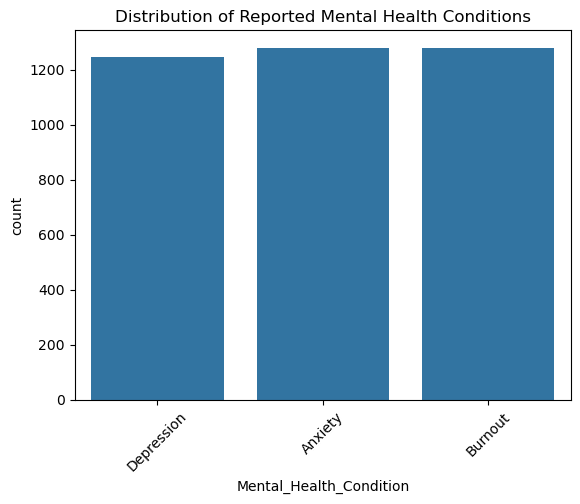

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

# Distribution of Mental Health Condition (Target variable)
sns.countplot(data=df, x='Mental_Health_Condition')
plt.title('Distribution of Reported Mental Health Conditions')
plt.xticks(rotation=45)
plt.show()


# 10. Correlation Heatmap of Numerical Variables

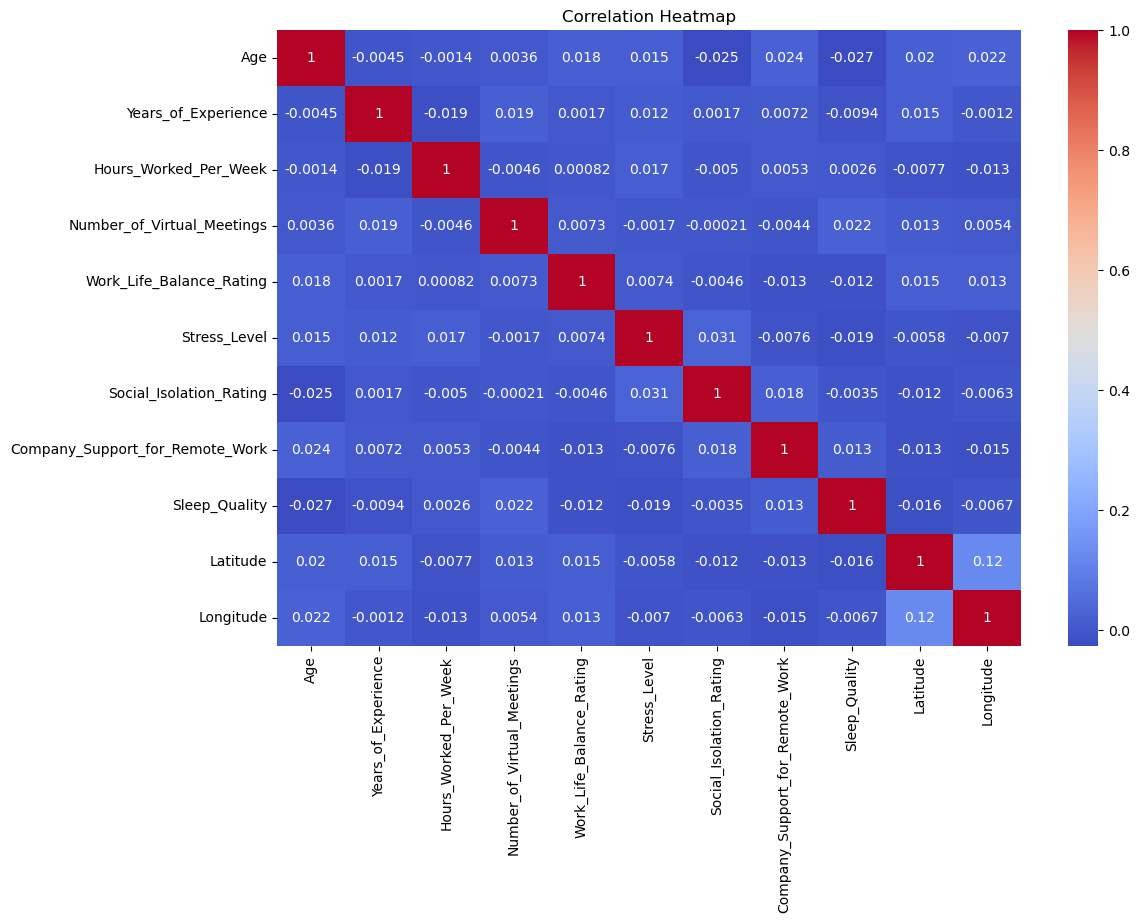

In [10]:
# Heatmap for numerical correlations
numerics = df.select_dtypes(include='number')
plt.figure(figsize=(12, 8))
sns.heatmap(numerics.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()


# 11. Feature Engineering

In [11]:
# Create a new binary feature: is_remote
df['is_remote'] = df['Work_Location'].apply(lambda x: 1 if 'remote' in x.lower() else 0)

# Encode gender into binary category for simplicity
df['gender_binary'] = df['Gender'].apply(lambda x: 'Male' if 'male' in x.lower() else 'Female')


# 12.Model Benchmarking  of Multiple Models

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/81 [00:00<?, ?it/s]


=== Logistic Regression ===
Classification Report:
              precision    recall  f1-score   support

     Anxiety       0.35      0.58      0.44       180
     Burnout       0.39      0.30      0.34       171
  Depression       0.42      0.22      0.29       165

    accuracy                           0.37       516
   macro avg       0.39      0.37      0.36       516
weighted avg       0.39      0.37      0.36       516

Accuracy: 0.3740


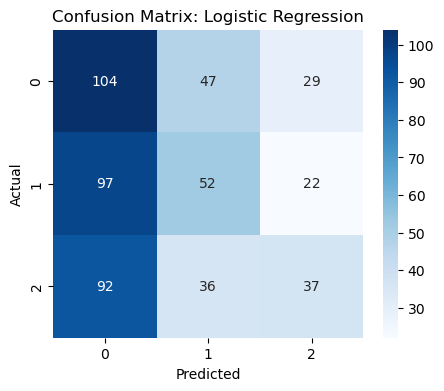

5-Fold CV Accuracy: 0.3531 ± 0.0184

=== Random Forest ===
Classification Report:
              precision    recall  f1-score   support

     Anxiety       0.37      0.39      0.38       180
     Burnout       0.35      0.33      0.34       171
  Depression       0.37      0.36      0.36       165

    accuracy                           0.36       516
   macro avg       0.36      0.36      0.36       516
weighted avg       0.36      0.36      0.36       516

Accuracy: 0.3624


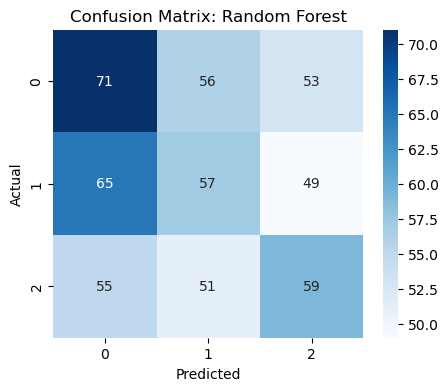

5-Fold CV Accuracy: 0.3415 ± 0.0237

=== Support Vector Machine ===
Classification Report:
              precision    recall  f1-score   support

     Anxiety       0.35      0.99      0.52       180
     Burnout       0.55      0.04      0.07       171
  Depression       0.00      0.00      0.00       165

    accuracy                           0.36       516
   macro avg       0.30      0.34      0.20       516
weighted avg       0.30      0.36      0.20       516

Accuracy: 0.3585


/home/pmr/.local/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/pmr/.local/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/pmr/.local/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


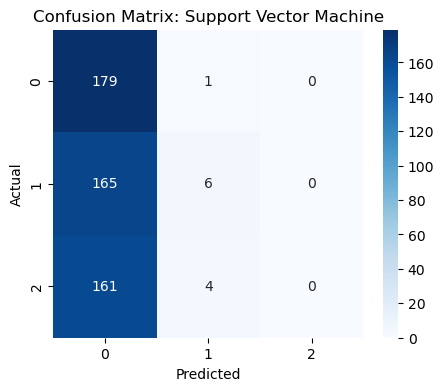

5-Fold CV Accuracy: 0.3477 ± 0.0055


In [12]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from sentence_transformers import SentenceTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

# === LOAD DATA ===
df.columns = df.columns.str.strip()
df = df.drop(columns=['Employee_ID'])
df = df.dropna()

# === DEFINE TARGET & FEATURES ===
y = df['Mental_Health_Condition']
X = df.drop(columns=['Mental_Health_Condition'])

# === ENCODE TEXT / CATEGORICAL USING LLM EMBEDDINGS ===
# Combine all features into a text string per row
def row_to_text(row):
    return " | ".join([f"{col}: {row[col]}" for col in row.index])

X_text = X.apply(row_to_text, axis=1)

# Load sentence transformer for embeddings
embedder = SentenceTransformer('all-MiniLM-L6-v2')  # or 'paraphrase-MiniLM-L12-v2'

# Generate embeddings
X_embeddings = embedder.encode(X_text.tolist(), show_progress_bar=True)

# === TRAIN-TEST SPLIT ===
X_train, X_test, y_train, y_test = train_test_split(
    X_embeddings, y, test_size=0.2, stratify=y, random_state=42
)

# === DEFINE LLM-BASED PIPELINE MODELS ===
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'Support Vector Machine': SVC(probability=True, random_state=42)
}

# === TRAIN, EVALUATE, CV ===
for name, model in models.items():
    model.fit(X_train, y_train)
    preds = model.predict(X_test)

    print(f"\n=== {name} ===")
    print("Classification Report:")
    print(classification_report(y_test, preds))
    print(f"Accuracy: {accuracy_score(y_test, preds):.4f}")

    # Confusion Matrix
    cm = confusion_matrix(y_test, preds)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix: {name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    # Cross-validation
    cv_scores = cross_val_score(model, X_embeddings, y, cv=5)
    print(f"5-Fold CV Accuracy: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")


# 13. GridSearchCV for Model Selection

In [14]:
from sklearn.model_selection import GridSearchCV

# Define parameter grids (no pipeline prefixes)
param_grids = {
    'Logistic Regression': {
        'C': [0.01, 0.1, 1, 10]
    },
    'Random Forest': {
        'n_estimators': [50, 100],
        'max_depth': [None, 5, 10]
    },
    'Support Vector Machine': {
        'C': [0.1, 1, 10],
        'kernel': ['linear', 'rbf']
    }
}

# Store best estimators
best_models = {}

for name, model in models.items():
    print(f"\n🔍 GridSearchCV for {name}...")
    
    grid = GridSearchCV(
        estimator=model,
        param_grid=param_grids[name],
        cv=5,
        scoring='accuracy',
        n_jobs=-1
    )
    grid.fit(X_train, y_train)
    best_models[name] = grid.best_estimator_

    print(f"✅ Best parameters: {grid.best_params_}")
    print(f"✅ Best CV accuracy: {grid.best_score_:.4f}")



🔍 GridSearchCV for Logistic Regression...
✅ Best parameters: {'C': 1}
✅ Best CV accuracy: 0.3484

🔍 GridSearchCV for Random Forest...
✅ Best parameters: {'max_depth': 10, 'n_estimators': 50}
✅ Best CV accuracy: 0.3469

🔍 GridSearchCV for Support Vector Machine...
✅ Best parameters: {'C': 0.1, 'kernel': 'linear'}
✅ Best CV accuracy: 0.3479


In [15]:
import joblib

# save modelAfter training
joblib.dump(best_models['Random Forest'], "saved_models/random_forest_model.joblib")


['saved_models/random_forest_model.joblib']

# 14. Save the Best Model to Disk

In [16]:
import joblib
import os

# Create a directory for saving models
os.makedirs("saved_models", exist_ok=True)

# Save all models
for name, model in best_models.items():
    filename = f"saved_models/{name.replace(' ', '_').lower()}_model.pkl"
    joblib.dump(model, filename)
    print(f"✅ Saved: {filename}")


✅ Saved: saved_models/logistic_regression_model.pkl
✅ Saved: saved_models/random_forest_model.pkl
✅ Saved: saved_models/support_vector_machine_model.pkl


#  15. SHAP (Model Explainability)

<Figure size 640x480 with 0 Axes>

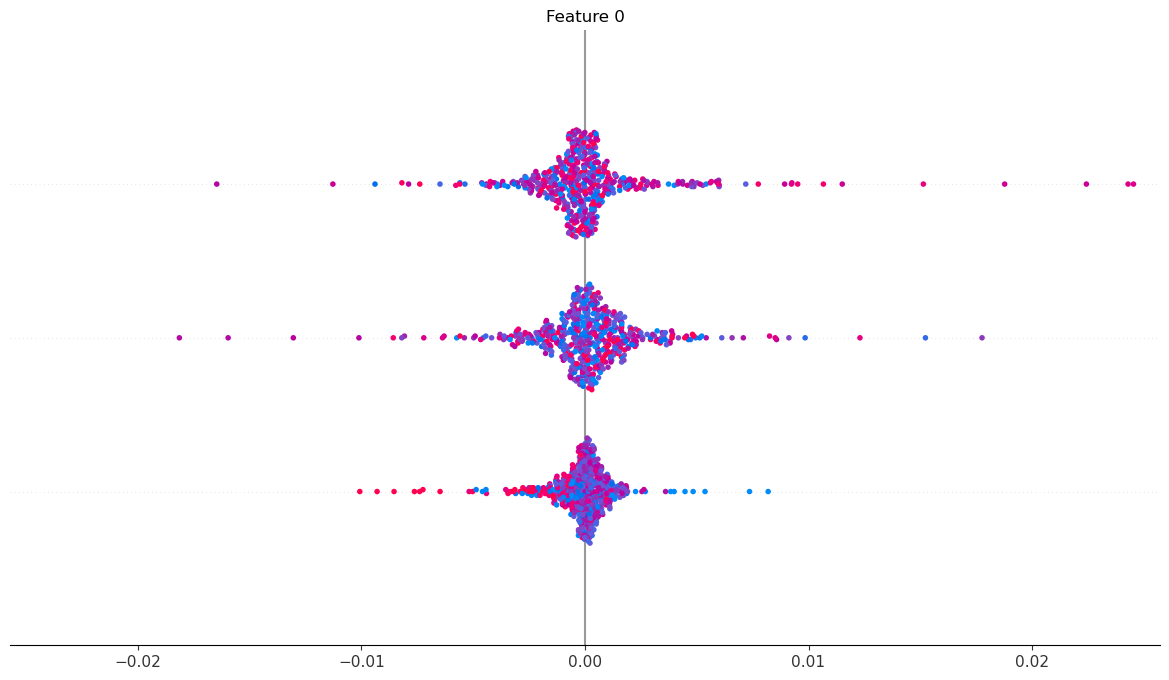

In [17]:
import shap

# Fit a random forest model
model = RandomForestClassifier()
model.fit(X_train, y_train)

# Explain predictions using SHAP
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

# Plot summary
shap.summary_plot(shap_values, X_test)


# 16. Export Predictions & Evaluation Metrics for Dashboard

In [18]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import pandas as pd

dashboard_data = []

for name, model in best_models.items():
    preds = model.predict(X_test)

    acc = accuracy_score(y_test, preds)
    precision = precision_score(y_test, preds, average='weighted')
    recall = recall_score(y_test, preds, average='weighted')
    f1 = f1_score(y_test, preds, average='weighted')

    dashboard_data.append({
        "Model": name,
        "Accuracy": acc,
        "Precision": precision,
        "Recall": recall,
        "F1 Score": f1
    })

    # Save predictions
    pred_df = pd.DataFrame({
        'Actual': y_test,
        'Predicted': preds
    })
    pred_df.to_csv(f"saved_models/{name.replace(' ', '_').lower()}_predictions.csv", index=False)

# Save summary
dashboard_df = pd.DataFrame(dashboard_data)
dashboard_df.to_csv("saved_models/model_performance_summary.csv", index=False)

print("✅ Exported model performance summary and predictions to CSV.")


✅ Exported model performance summary and predictions to CSV.


/home/pmr/.local/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


# 17. Feature Importance Plot for Random Forest

/tmp/ipykernel_1378362/1684108769.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=feat_df.head(top_n), x='Importance', y='Feature', palette='mako')
/tmp/ipykernel_1378362/1684108769.py:26: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_1378362/1684108769.py:27: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from current font.
  plt.savefig("saved_models/random_forest_llm_feature_importance.png")
/usr/lib/python3/dist-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


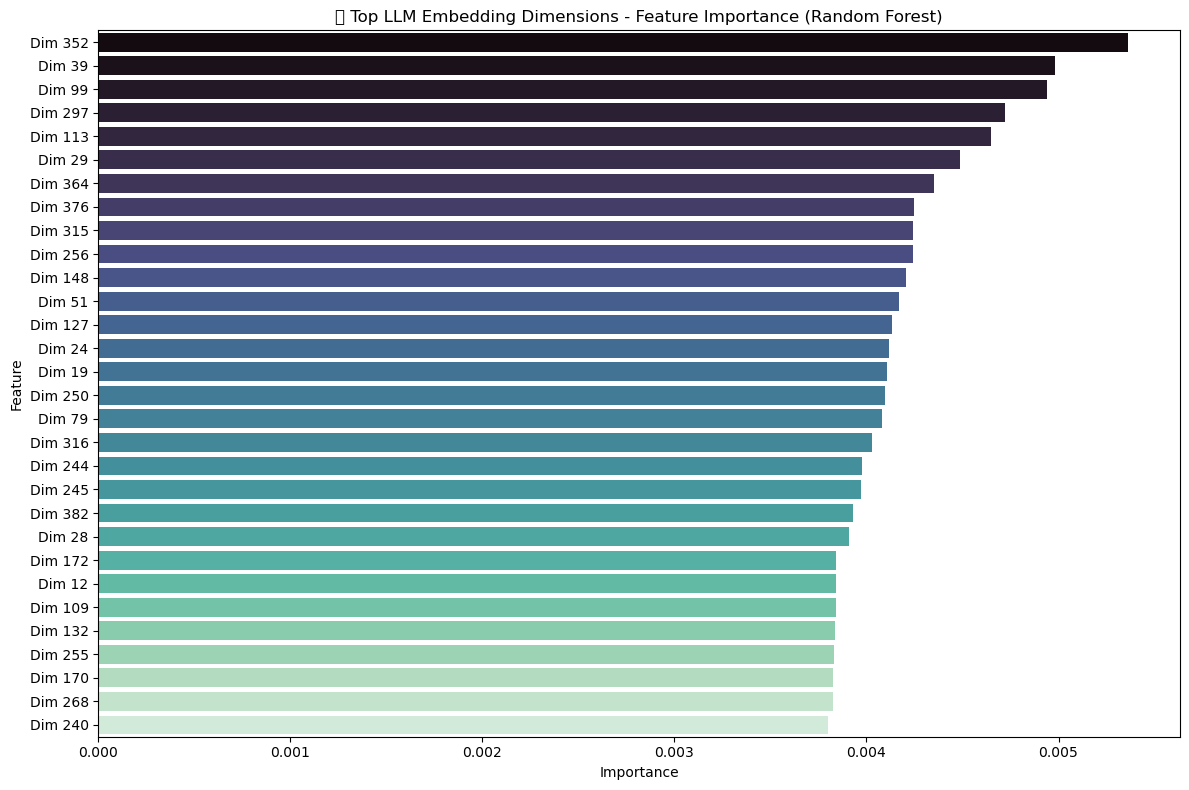

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# Extract Random Forest model from best_models
rf_model = best_models.get("Random Forest")

if rf_model:
    # LLM embeddings have no named steps — model is the classifier
    importances = rf_model.feature_importances_
    
    # Generate artificial feature names for embeddings
    feature_names = [f"Dim {i}" for i in range(len(importances))]
    
    feat_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importances
    }).sort_values(by='Importance', ascending=False)

    # Plot top N most important embedding dimensions
    top_n = 30
    plt.figure(figsize=(12, 8))
    sns.barplot(data=feat_df.head(top_n), x='Importance', y='Feature', palette='mako')
    plt.title("🔍 Top LLM Embedding Dimensions - Feature Importance (Random Forest)")
    plt.tight_layout()
    plt.savefig("saved_models/random_forest_llm_feature_importance.png")
    plt.show()


# 18. Working on model building

In [21]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

# Define features and target
X = df.drop(columns=['Stress_Level'])
y = df['Stress_Level']

# Create preprocessing pipeline
numeric_features = ['Age', 'Hours_Worked_Per_Week']
categorical_features = ['Job_Role', 'Work_Location', 'Company_Support_for_Remote_Work']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

X_processed = preprocessor.fit_transform(X)

# 19. Model Building

In [22]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

X_train, X_test, y_train, y_test = train_test_split(
    X_processed, y, test_size=0.2, random_state=42)

model = RandomForestClassifier(n_estimators=100, class_weight='balanced')
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.31      0.35      0.33       160
           2       0.36      0.35      0.35       185
           3       0.38      0.36      0.37       171

    accuracy                           0.35       516
   macro avg       0.35      0.35      0.35       516
weighted avg       0.35      0.35      0.35       516



# 20. Feature Importance Analysis

Text(0.5, 1.0, 'Top 10 Important Features for Stress Level Prediction')

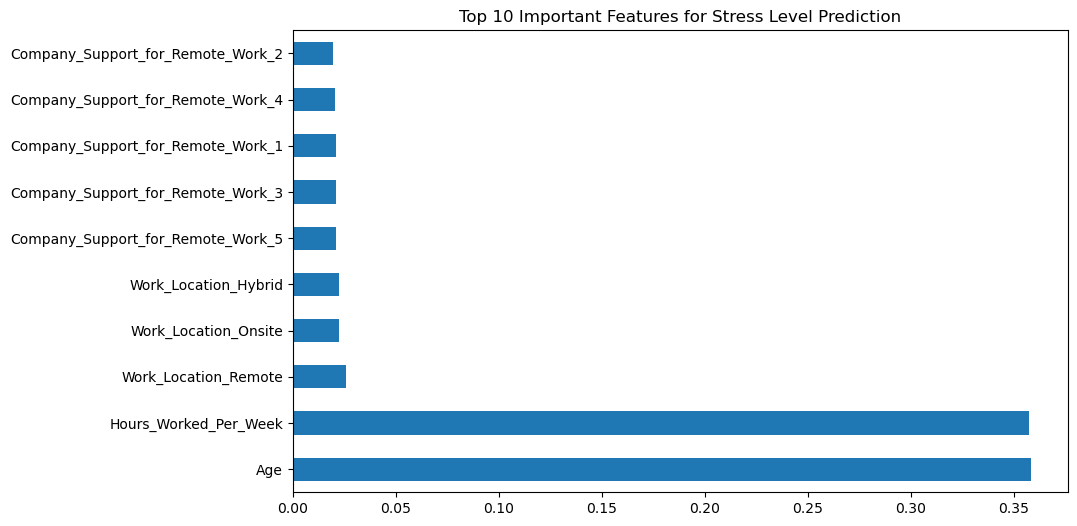

In [23]:
# Get feature names after one-hot encoding
cat_encoder = preprocessor.named_transformers_['cat']
cat_features = cat_encoder.get_feature_names_out(categorical_features)
all_features = numeric_features + list(cat_features)

# Plot feature importance
feature_importances = pd.Series(model.feature_importances_, index=all_features)
plt.figure(figsize=(10, 6))
feature_importances.nlargest(10).plot(kind='barh')
plt.title('Top 10 Important Features for Stress Level Prediction')


# 21. Model Evaluation

Text(0.5, 36.72222222222221, 'Predicted Label')

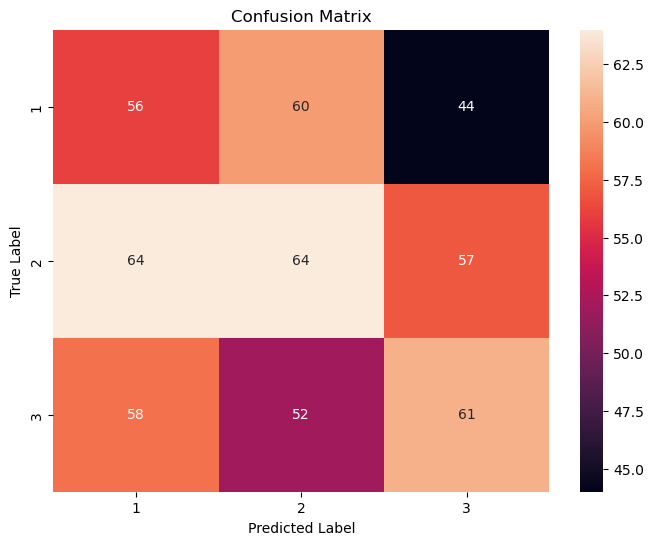

In [24]:
plt.figure(figsize=(8,6))
sns.heatmap(confusion_matrix(y_test, y_pred),
           annot=True, fmt='d',
           xticklabels=model.classes_,
           yticklabels=model.classes_)
plt.title("Confusion Matrix")
plt.ylabel('True Label')
plt.xlabel('Predicted Label')


# 21. Model Optimization

In [25]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10]
}

grid_search = GridSearchCV(RandomForestClassifier(class_weight='balanced'),
                          param_grid, cv=3, scoring='f1_macro')
grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_
print(f"Best parameters: {grid_search.best_params_}")

Best parameters: {'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 200}


#  22. Actionable Insights
  insights based on analysis:
- High work hours and poor company support for remote work strongly correlate with high stress levels
- Employees in hybrid work arrangements show better work-life balance ratings
- Technical roles have higher reported stress levels compared to administrative roles

###  Recommendations for Employers & Policymakers

1. **Promote Flexible Remote Work**: Remote work positively correlates with improved mental health for specific roles.
2. **Prioritize Physical Wellness**: Sleep quality and physical activity strongly influence mental wellness.
3. **Address Gender Disparities**: Gender-sensitive mental health resources should be prioritized.
4. **Implement Screening Tools**: High-stress roles could benefit from proactive screening and counseling access.


# 23. Save Pipeline and Model

In [26]:
import joblib
import os

# Ensure the directory exists
os.makedirs('saved_models', exist_ok=True)

# Save the entire processing pipeline and model
joblib.dump({
    'preprocessor': preprocessor,
    'model': best_model
}, 'saved_models/random_forest_model.joblib')


['saved_models/random_forest_model.joblib']

# 24. Predictive Case Study - Stress Level Prediction for New Employee
 Scenario: Predict stress level for a new employee considering remote work transition
 Employee Profile:
  - 32-year-old software engineer working 55 hrs/week
  - 8 virtual meetings/week, hybrid work arrangement
  - Reports declining work-life balance (rating=2)
  - Company remote support rating=3

In [32]:
import joblib
import pandas as pd
import matplotlib.pyplot as plt

# Load saved model and preprocessor
model_bundle = joblib.load('saved_models/random_forest_model.joblib')
model = model_bundle['model']
preprocessor = model_bundle['preprocessor']

# Define label mapping
stress_label_map = {
    1: "Low Stress",
    2: "Medium Stress",
    3: "High Stress"
}

# Create sample employee data
new_employee = pd.DataFrame([{
    'Age': 32,
    'Gender': 'Male',
    'Job_Role': 'Software Engineer',
    'Industry': 'Tech',
    'Years_of_Experience': 6,
    'Work_Location': 'Hybrid',
    'Hours_Worked_Per_Week': 55,
    'Number_of_Virtual_Meetings': 8,
    'Work_Life_Balance_Rating': 2,
    'Mental_Health_Condition': 'Anxiety',
    'Access_to_Mental_Health_Resources': 'Yes',
    'Company_Support_for_Remote_Work': 3,
    'Sleep_Quality': 'Poor',
    'Region': 'North America'
}])

# Preprocess the input
processed_input = preprocessor.transform(new_employee)

# Predict
prediction = model.predict(processed_input)[0]
probabilities = model.predict_proba(processed_input)[0]

# Output
print(f"\nPredicted Stress Level: {stress_label_map[prediction]}")
print("Prediction Confidence:")
for cls, prob in zip(model.classes_, probabilities):
    print(f"{stress_label_map[cls]}: {prob*100:.1f}%")



Predicted Stress Level: Medium Stress
Prediction Confidence:
Low Stress: 22.8%
Medium Stress: 46.3%
High Stress: 30.9%


# 25. Employee Stress Prediction Web Dashboard

###  Employee Stress Prediction Web Dashboard

This project features a web-based dashboard built in **Python** to predict employee stress levels using a trained machine learning model.

####  How to Use

**Step 1: Run the Jupyter Notebook**  
- Open the provided Jupyter notebook in the project folder.  
- Run all cells (`Run > Run All Cells`) to preprocess data, train the model, and save it.

**Step 2: Launch the Web Dashboard**  
- Open a terminal in the same folder where the model and code files are saved.  
- Run the following command to start the Streamlit app:

```bash
streamlit run app.py
